In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pySAMetrics
import matplotlib.pyplot as plt
from pySAMetrics.Simulation import Simulation
from pySAMetrics.utils import generate_simulation_paths
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
simu_list=[]

### add control case
# Example usage
velocity = '0'
temperature='300'
bowen_ratio='1'
microphysic='1'

paths = generate_simulation_paths(velocity=velocity, temperature=temperature, bowen_ratio=bowen_ratio, microphysic=microphysic, folder_path='/home/ec2-user/DeepCloudLab/outputs')

print(paths)

simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                velocity=velocity,
                temperature=temperature,
                bowen_ratio=bowen_ratio,
                microphysic=microphysic)

simu.load(backup_folder_path='/home/ec2-user/DeepCloudLab/processed_classes')
simu_list.append(simu)


### add shear cases
for velocity in tqdm(['2.5']):#, '5', '10', '20']):
    temperature='300'
    bowen_ratio='1'
    microphysic='1'

    paths = generate_simulation_paths(velocity=velocity, temperature=temperature, bowen_ratio=bowen_ratio, microphysic=microphysic, folder_path='/home/ec2-user/DeepCloudLab/outputs')

    print(paths)

    simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                    velocity=velocity,
                    temperature=temperature,
                    bowen_ratio=bowen_ratio,
                    microphysic=microphysic)

    simu.load(backup_folder_path='/home/ec2-user/DeepCloudLab/processed_classes')
    simu_list.append(simu)



{'path_3d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/3D/dataset_3d.nc', 'path_2d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/2D/RCE_T300_U0_SAM1MOM_B1_128x128x64_64.2Dcom_1.nc', 'path_1d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/1D/RCE_T300_U0_SAM1MOM_B1_128x128x64.nc'}


In [31]:
[simu.name for simu in simu_list[:5]]

['RCE_T300_U0_B1_M1', 'RCE_T300_U2.5_B1_M1']

In [32]:
nz,nX=64, 50

In [33]:
array_isentropic_all=[]

one_hot_encoding = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]

# Loop through the simulations and add new variables
winds = []
for i, simu in enumerate(simu_list[:2]):
    new_variable = simu.dataset_isentropic.RHO_W.values  # Extract the new variabl
    array_isentropic_all.append(new_variable)
    winds.append([one_hot_encoding[i]]*len(new_variable))

array_isentropic_all=np.array(array_isentropic_all)
array_winds_all=np.array([j for ii in winds for j in ii])
reshaped_data = array_isentropic_all.reshape(-1, 64, 50)


In [34]:
reshaped_data = np.nan_to_num(reshaped_data)
mean_norm_data, std_norm_data = reshaped_data.mean(), reshaped_data.std()
print('mean', 'std', reshaped_data.mean(), reshaped_data.std())
reshaped_data = (reshaped_data - reshaped_data.mean()) / reshaped_data.std()  # Normalize data
reshaped_data = reshaped_data.reshape((reshaped_data.shape[0], -1))
reshaped_data = np.concatenate([reshaped_data, array_winds_all], axis=-1)

mean std 0.5295836408742808 1.5313830478817303


In [35]:
reshaped_data.shape

(962, 3205)

In [36]:
# Set the split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
total_samples = reshaped_data.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle the data (optional, but common in dataset splitting)
indices = np.random.permutation(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = reshaped_data[train_indices]
val_data = reshaped_data[val_indices]
test_data = reshaped_data[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching during training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
# Define the VAE model as a fully connected network
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=400, latent_dim=100, device='cpu'):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )
        
        # Latent space (mean and log variance)
        self.mean_layer = nn.Linear(latent_dim, 6)
        self.logvar_layer = nn.Linear(latent_dim, 6)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.LeakyReLU(0.2),
            nn.Linear(12, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            #nn.Sigmoid()  # Output scaled between 0 and 1
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        epsilon = torch.randn_like(std)  # Random noise
        return mean + epsilon * std  # Reparameterization trick
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        return self.decode(z), mean, logvar

# Loss function (reconstruction loss + KL divergence)
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kld_loss



In [11]:
#input_dim, 50*64

In [38]:
_, input_dim = reshaped_data.shape

# Instantiate the VAE
latent_dim = 100  # Latent space dimension
vae = VAE(input_dim=input_dim, latent_dim=latent_dim)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=5e-5)

In [71]:
# Early stopping parameters
patience = 20  # Number of epochs to wait for improvement before stopping
min_delta = 0  # Minimum change to qualify as an improvement
best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 0  # Count how long the validation loss hasn't improved

# Training loop
epochs = 500
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar, beta=4)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}", end="\r")
    # Validation step
    vae.eval()  # Set VAE to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_batch in val_loader:
            x_val = val_batch[0]
            recon_x_val, mu_val, logvar_val = vae(x_val)
            val_loss = vae_loss(recon_x_val, x_val, mu_val, logvar_val, beta=1)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}",end="\r")

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
    
    # Check if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


# Ensure the final epoch result is printed properly
print(f"Training Complete. Final Loss: {total_loss / len(train_loader.dataset):.4f}")



Early stopping triggered at epoch 35
Training Complete. Final Loss: 835.2299


In [55]:
# Test the VAE with a batch of images
vae.eval()  # Set VAE to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of images from the DataLoader
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
images = next(data_iter)  # Get a batch of images

# Since there's only one tensor in the dataset, access it with [0]
images = images[0].to(device)  # Move to GPU if available

# Pass the images through the VAE
with torch.no_grad():
    reconstructed_images = vae(images)  # Decode the images
    reconstructed_images = reconstructed_images[0][:,:-5].reshape(32, nz, nX)


"""
# Visualize the original and reconstructed images
n_images = 10  # Number of images to display
fig, axes = plt.subplots(n_images, 2, figsize=(9, 7 * n_images))



for i in range(n_images):
    # Original Image
    ax = axes[i, 0]
    ax.contourf(XX,YY,images[i][0].cpu().numpy().squeeze(), cmap='viridis')  # Assuming images are (C, H, W)
    ax.set_title('Original Image')
    ax.axis('off')
    ax.set_ylim(0,17)

    # Reconstructed Image
    ax = axes[i, 1]
    # Squeeze the channel dimension if necessary and transpose to (H, W)
    reconstructed_img = reconstructed_images[0][i].cpu().numpy().squeeze()  # Shape (64, 50)
    ax.contourf(XX,YY,reconstructed_img, cmap='viridis')  # Display grayscale image
    ax.set_title('Reconstructed Image')
    ax.axis('off')
    ax.set_ylim(0,17)

plt.tight_layout()
plt.show()
"""

"\n# Visualize the original and reconstructed images\nn_images = 10  # Number of images to display\nfig, axes = plt.subplots(n_images, 2, figsize=(9, 7 * n_images))\n\n\n\nfor i in range(n_images):\n    # Original Image\n    ax = axes[i, 0]\n    ax.contourf(XX,YY,images[i][0].cpu().numpy().squeeze(), cmap='viridis')  # Assuming images are (C, H, W)\n    ax.set_title('Original Image')\n    ax.axis('off')\n    ax.set_ylim(0,17)\n\n    # Reconstructed Image\n    ax = axes[i, 1]\n    # Squeeze the channel dimension if necessary and transpose to (H, W)\n    reconstructed_img = reconstructed_images[0][i].cpu().numpy().squeeze()  # Shape (64, 50)\n    ax.contourf(XX,YY,reconstructed_img, cmap='viridis')  # Display grayscale image\n    ax.set_title('Reconstructed Image')\n    ax.axis('off')\n    ax.set_ylim(0,17)\n\nplt.tight_layout()\nplt.show()\n"

In [56]:
reconstructed_images.shape

torch.Size([32, 64, 50])

(0.0, 17.0)

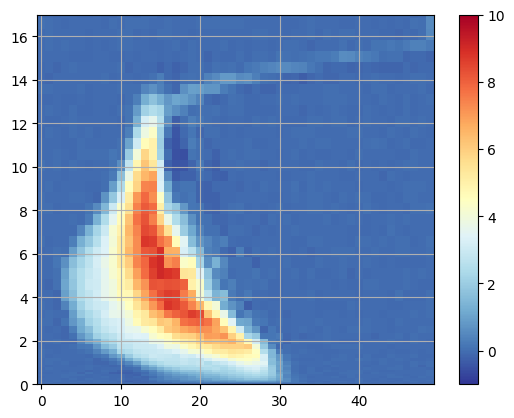

In [57]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
reconstructed_scale_image=reconstructed_images[10]*std_norm_data+mean_norm_data
plt.pcolormesh(XX,ZZ, reconstructed_scale_image,cmap='RdYlBu_r', vmin=-1, vmax=10)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)

(0.0, 17.0)

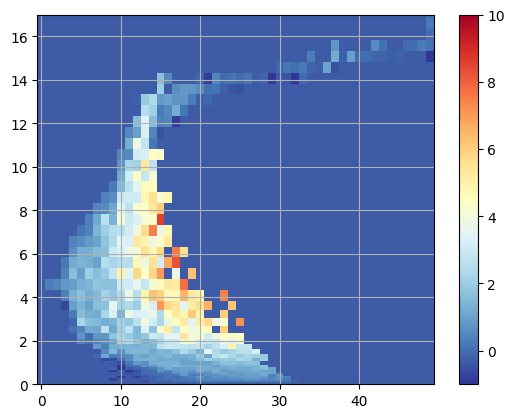

In [58]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, images[10][:-5].reshape(64, 50),cmap='RdYlBu_r', vmin=-1, vmax=10)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)


(0.0, 17.0)

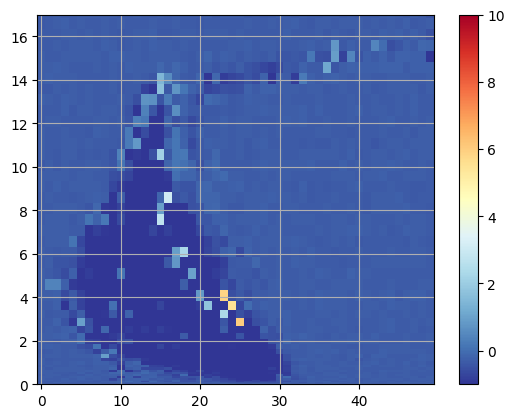

In [59]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, images[10][:-5].reshape(64, 50)-reconstructed_scale_image, cmap='RdYlBu_r', vmin=-1, vmax=10)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)

In [60]:
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Encode all data from the train_loader into the latent space (mu)
all_mu = []

# Loop over your train_loader to collect the latent means (mu)
vae.eval()  # Ensure the VAE is in evaluation mode
with torch.no_grad():
    for batch in train_loader:
        x = batch[0]  # assuming the data comes as (input, label) tuples
        x = x.to(device)  # Move input to the appropriate device
        mu, _ = vae.encode(x)  # Get the latent means (mu)
        all_mu.append(mu)

# Concatenate all mu's into one large tensor
all_mu = torch.cat(all_mu, dim=0)

# Perform k-means clustering on the latent means (mu)
nb_clusters = 3
kmeans = KMeans(n_clusters=nb_clusters)
kmeans.fit(all_mu.cpu().numpy())  # Convert to numpy for sklearn

# Get the barycenters (cluster centroids)
barycenters = kmeans.cluster_centers_

# Convert the barycenters back to torch tensors and move to the appropriate device
barycenters_tensor = torch.tensor(barycenters).float().to(device)

# Decode the barycenters to get the reconstructed images
with torch.no_grad():
    reconstructed_modes = vae.decode(barycenters_tensor)
    reconstructed_modes = reconstructed_modes[:,:-5].reshape(nb_clusters, nz, nX)


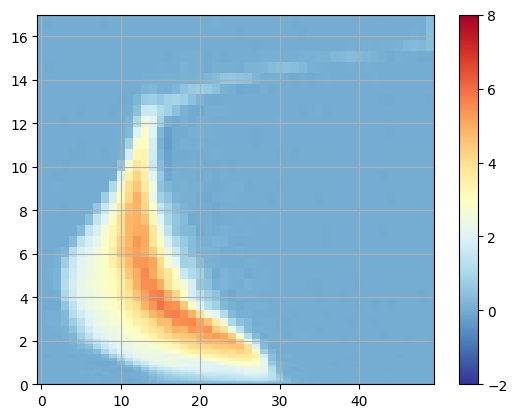

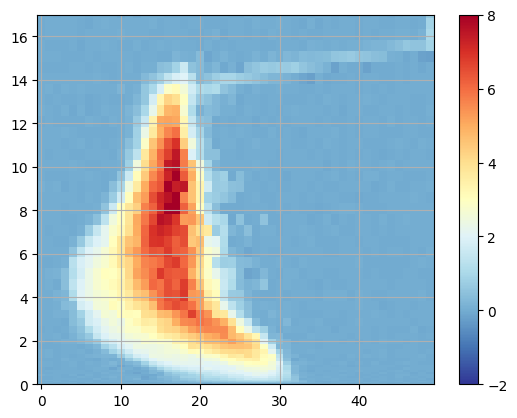

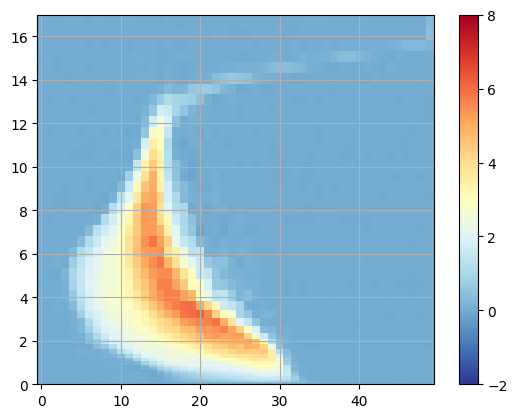

In [61]:

for mode in reconstructed_modes:
    fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
    XX,ZZ = np.meshgrid(fmse, z)
    #mode[np.absolute(mode)<0.5]=np.nan

    plt.pcolormesh(XX,ZZ, mode*std_norm_data+mean_norm_data,cmap='RdYlBu_r', vmin=-2, vmax=8)
    plt.colorbar()
    plt.grid(True)
    plt.ylim(0,17)
    plt.show()

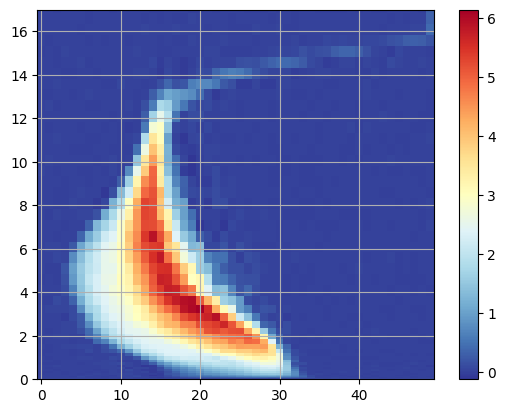

In [62]:


fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
#mode[np.absolute(mode)<0.5]=np.nan

plt.pcolormesh(XX,ZZ, (reconstructed_modes[2])*std_norm_data+mean_norm_data,cmap='RdYlBu_r')#, vmin=-2, vmax=8)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:37<00:00, 18.81s/it]


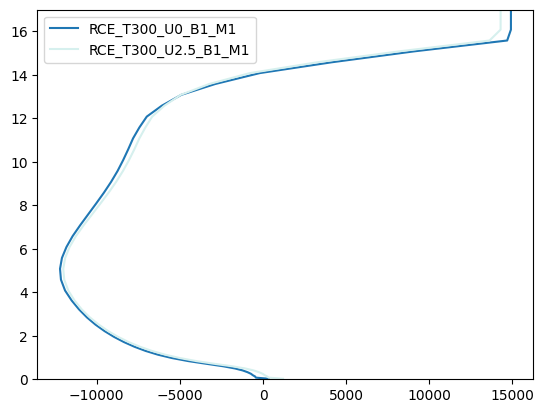

In [63]:
for simu in tqdm(simu_list):
    #plt.pcolormesh(XX,ZZ, simu.dataset_isentropic.RHO_W.values[10])
    simu_fmse = np.nanmean(simu.dataset_computed_3d.FMSE.values, axis=(0,2,3))
    plt.plot(simu_fmse-np.mean(simu_fmse), simu.dataset_3d.z.values/1000, label=simu.name, color=simu.color)
    plt.ylim(0,17)
plt.legend()
    #plt.show()

In [67]:
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Encode all data from the train_loader into the latent space (mu)
all_mu = []

# Loop over your train_loader to collect the latent means (mu)
vae.eval()  # Ensure the VAE is in evaluation mode
with torch.no_grad():
    for batch in train_loader:
        x = batch[0]  # assuming the data comes as (input, label) tuples
        x = x.to(device)  # Move input to the appropriate device
        mu, _ = vae.encode(x)  # Get the latent means (mu)
        all_mu.append(mu)

# Concatenate all mu's into one large tensor
all_mu = torch.cat(all_mu, dim=0)

# Perform PCA on the latent means (mu)
n_components = 3  # Choose how many components you want to keep
pca = PCA(n_components=n_components)
all_mu_pca = pca.fit_transform(all_mu.cpu().numpy())  # Convert to numpy for sklearn PCA


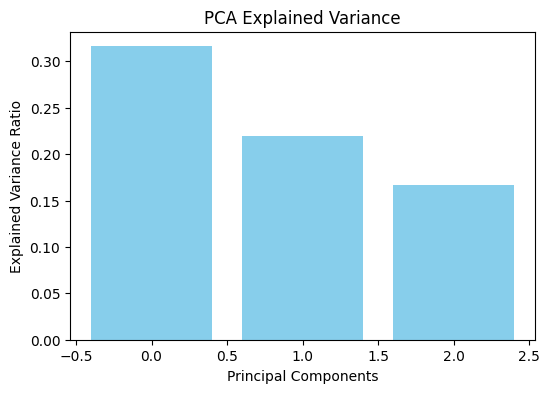

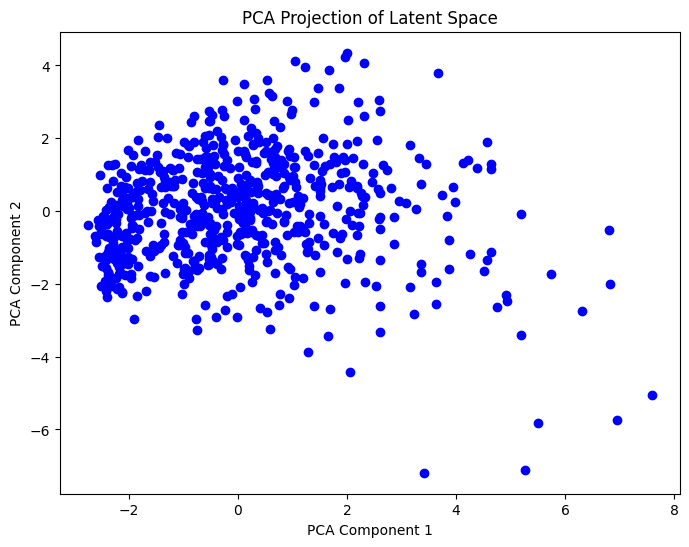

In [68]:
# Optional: Visualize the explained variance ratio
plt.figure(figsize=(6,4))
plt.bar(range(n_components), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

# Visualizing PCA projections (for example, using the first 2 components)
plt.figure(figsize=(8,6))
plt.scatter(all_mu_pca[:, 0], all_mu_pca[:, 1], c='b', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Latent Space')
plt.show()

# You can now use 'all_mu_pca' for further analysis or processing.


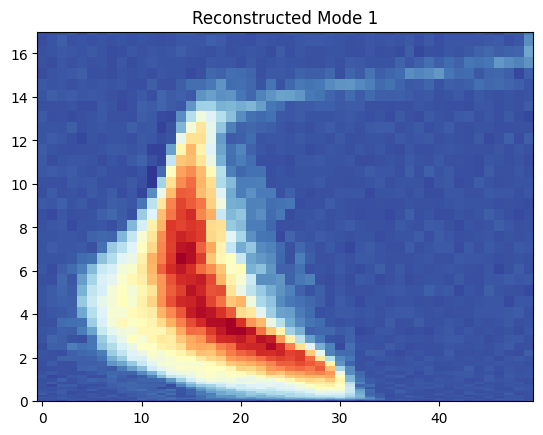

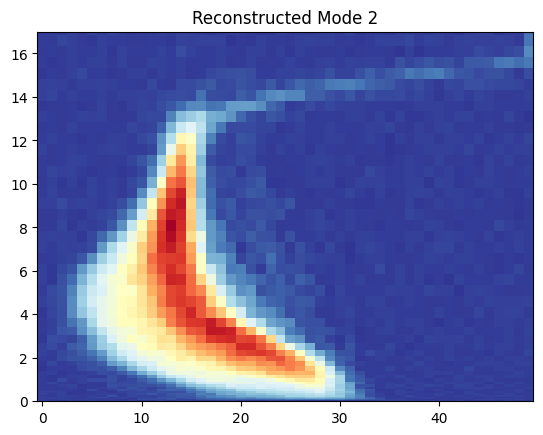

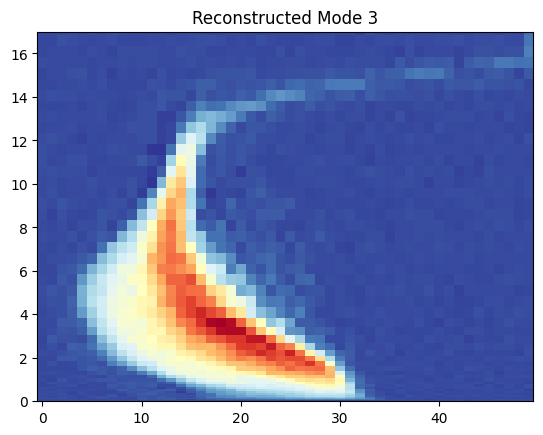

In [69]:
# Get the principal components' coordinates (analogous to barycenters in KMeans)
principal_modes = torch.tensor(pca.components_).float().to(device)  # Convert PCA components to torch tensors

# Decode the principal components to get the reconstructed images (modes)
with torch.no_grad():
    reconstructed_modes = vae.decode(principal_modes)
    reconstructed_modes = reconstructed_modes[:,:-5].reshape(n_components, nz, nX)  # Reshape based on your data dimensions

# Plot or save the reconstructed modes (images)
for i in range(n_components):
    plt.pcolormesh(XX,ZZ, reconstructed_modes[i].cpu().numpy(), cmap='RdYlBu_r')
    plt.title(f"Reconstructed Mode {i+1}")
    plt.ylim(0,17)
    plt.show()


In [ ]:
#### with conv

In [72]:
array_isentropic_all=[]

one_hot_encoding = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]

# Loop through the simulations and add new variables
winds = []
for i, simu in enumerate(simu_list[:2]):
    new_variable = simu.dataset_isentropic.RHO_W.values  # Extract the new variabl
    array_isentropic_all.append(new_variable)
    #winds.append([one_hot_encoding[i]]*len(new_variable))

array_isentropic_all=np.array(array_isentropic_all)
#array_winds_all=np.array([j for ii in winds for j in ii])
reshaped_data = array_isentropic_all.reshape(-1, 64, 50)

reshaped_data = np.nan_to_num(reshaped_data)
mean_norm_data, std_norm_data = reshaped_data.mean(), reshaped_data.std()
print('mean', 'std', reshaped_data.mean(), reshaped_data.std())
reshaped_data = (reshaped_data - reshaped_data.mean()) / reshaped_data.std()  # Normalize data
#reshaped_data = reshaped_data.reshape((reshaped_data.shape[0], -1))
#reshaped_data = np.concatenate([reshaped_data, array_winds_all], axis=-1)


# Set the split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
total_samples = reshaped_data.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle the data (optional, but common in dataset splitting)
indices = np.random.permutation(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = reshaped_data[train_indices]
val_data = reshaped_data[val_indices]
test_data = reshaped_data[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching during training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

mean std 0.5295836408742808 1.5313830478817303


In [88]:
len(train_loader)

22

In [141]:
import torch
import torch.nn as nn


class VAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=100, hidden_channels=32):
        super(VAE, self).__init__()
        
        # Encoder: Conv2D layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=4, stride=2, padding=1),  # (batch_size, hidden_channels, 32, 25)
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=4, stride=2, padding=1),  # (batch_size, hidden_channels*2, 16, 13)
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=4, stride=2, padding=1),  # (batch_size, hidden_channels*4, 8, 7)
            nn.LeakyReLU(0.2),
        )
        
        # Corrected Flattened Size
        self.flat_dim = 128 * 8 * 8  # (batch_size, hidden_channels*4, 8, 7) is the output shape of the last Conv2d layer
        
        # Latent space (mean and log variance)
        self.fc_mean = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)
        
        # Decoder: ConvTranspose2D layers
        self.decoder_fc = nn.Linear(latent_dim, self.flat_dim)  # To match the flattened size
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2, kernel_size=4, stride=2, padding=1),  # (batch_size, hidden_channels*2, 16, 13)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, kernel_size=4, stride=2, padding=1),  # (batch_size, hidden_channels, 32, 25)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(hidden_channels, input_channels, kernel_size=4, stride=2, padding=1),  # (batch_size, input_channels, 64, 50)
            nn.Sigmoid()  # Output in range [0, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        #print('encode', x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        #print(mean.shape, logvar.shape)
        std = torch.exp(0.5 * logvar)  # Standard deviation
        epsilon = torch.randn_like(std)  # Random noise
        return mean + epsilon * std  # Reparameterization trick
    
    def decode(self, z):
        #print('decode from', z.shape)
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 128, 8, 8)  # Reshape to match the feature map dimensions
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        return self.decode(z), mean, logvar


# Loss function (reconstruction loss + KL divergence)
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss


In [145]:
#_, input_dim = reshaped_data.shape

# Instantiate the VAE
vae = VAE()

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=5e-5)

In [146]:
# Early stopping parameters
patience = 20  # Number of epochs to wait for improvement before stopping
min_delta = 0  # Minimum change to qualify as an improvement
best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 0  # Count how long the validation loss hasn't improved

# Training loop
epochs = 500
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x = batch[0]
        #print(x.shape)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        #print('recon_x', recon_x.shape)
        loss = vae_loss(recon_x, x, mu, logvar, beta=0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}", end="\r")
    # Validation step
    vae.eval()  # Set VAE to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_batch in val_loader:
            x_val = val_batch[0]
            recon_x_val, mu_val, logvar_val = vae(x_val)
            val_loss = vae_loss(recon_x_val, x_val, mu_val, logvar_val, beta=1)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}",end="\r")

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
    
    # Check if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


# Ensure the final epoch result is printed properly
print(f"Training Complete. Final Loss: {total_loss / len(train_loader.dataset):.4f}")



Early stopping triggered at epoch 21
Training Complete. Final Loss: 2601.5781


In [163]:
# Test the VAE with a batch of images
vae.eval()  # Set VAE to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of images from the DataLoader
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
images = next(data_iter)  # Get a batch of images

# Since there's only one tensor in the dataset, access it with [0]
images = images[0].to(device)  # Move to GPU if available

print(images.shape)

# Pass the images through the VAE
with torch.no_grad():
    images.unsqueeze(1)
    reconstructed_images = vae(images)  # Decode the images
    print('lll', reconstructed_images[0].shape)
    reconstructed_images = reconstructed_images[0][:,0,:,:]



torch.Size([32, 1, 64, 64])
lll torch.Size([32, 1, 64, 64])


In [164]:
reconstructed_images.shape

torch.Size([32, 64, 64])

(0.0, 17.0)

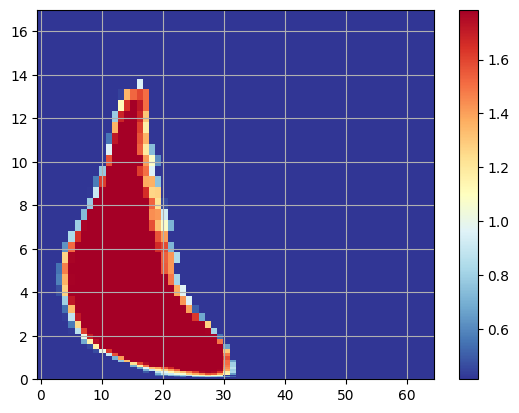

In [167]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
fmse2 = np.linspace(0,64, 64)
XX,ZZ = np.meshgrid(fmse2,z)
reconstructed_scale_image=reconstructed_images[10]*std_norm_data+mean_norm_data
plt.pcolormesh(XX,ZZ, reconstructed_scale_image,cmap='RdYlBu_r')#, vmin=-1, vmax=10)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)

In [134]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

array_isentropic_all = []

# One-hot encoding (optional)
one_hot_encoding = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]

# Loop through the simulations and extract data
for i, simu in enumerate(simu_list[:2]):  # Use the first 2 simulations as example
    new_variable = simu.dataset_isentropic.RHO_W.values  # Extract new variable
    img_zeroes=np.zeros((481, 64,64))
    img_zeroes[:,:,:50] = new_variable
    array_isentropic_all.append(img_zeroes)

# Convert to NumPy array and reshape
array_isentropic_all = np.array(array_isentropic_all)
reshaped_data = array_isentropic_all.reshape(-1, 64, 64)  # Reshape for images

# Handle NaNs and normalize
reshaped_data = np.nan_to_num(reshaped_data)
mean_norm_data, std_norm_data = reshaped_data.mean(), reshaped_data.std()
reshaped_data = (reshaped_data - mean_norm_data) / std_norm_data  # Normalize

# Split percentages
train_split, val_split, test_split = 0.7, 0.15, 0.15

# Calculate split indices
total_samples = reshaped_data.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle data and get split indices
indices = np.random.permutation(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = reshaped_data[train_indices]
val_data = reshaped_data[val_indices]
test_data = reshaped_data[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Reshape the input to include the channel dimension
train_tensor = train_tensor.unsqueeze(1)  # Add channel dimension (1 channel for grayscale)
val_tensor = val_tensor.unsqueeze(1)
test_tensor = test_tensor.unsqueeze(1)

# Now your data should be in the form (batch_size, 1, height, width)
print(train_tensor.shape)  # Expected output: torch.Size([32, 1, 64, 50])
print(val_tensor.shape)
print(test_tensor.shape)


# Create TensorDatasets (no labels, just the data)
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([673, 1, 64, 64])
torch.Size([144, 1, 64, 64])
torch.Size([145, 1, 64, 64])
